In [1]:
# Preliminaries
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from umc_module import main_program # import self define module

In [2]:
# data generation
def data_generator(n,mu,prob,group=[0.7,0.3]):
    # input vector mu=(mu1,mu2) stands for different means for two groups
    # input vector prob=(p1,p2) stands for different accuracy for group,value

    # generate real data
    output=pd.DataFrame(columns=['label','value','real_label','real_value'])
    output['real_label']=np.random.choice(a=[0,1],size=n,replace=True,p=group) # group_0 information, 0 otherwise
    srl1=sum(output['real_label'])
    output.loc[output['real_label']==0,'real_value']=np.random.choice(a=[0,1],size=n-srl1,replace=True,p=[1-mu[0],mu[0]])
    output.loc[output['real_label']==1,'real_value']=np.random.choice(a=[0,1],size=srl1,replace=True,p=[1-mu[1],mu[1]])

    # generate inaccurate data
    output.loc[output['real_label']==0,'label']=np.random.choice(a=[0,1],size=n-srl1,replace=True,p=[prob[0],1-prob[0]])
    output.loc[output['real_label']==1,'label']=np.random.choice(a=[0,1],size=srl1,replace=True,p=[1-prob[0],prob[0]])

    srv1=sum(output['real_value'])
    output.loc[output['real_value']==0,'value']=np.random.choice(a=[0,1],size=n-srv1,replace=True,p=[prob[1],1-prob[1]])
    output.loc[output['real_value']==1,'value']=np.random.choice(a=[0,1],size=srv1,replace=True,p=[1-prob[1],prob[1]])
    
    return(output.astype(int))

In [4]:
# compare t-test on 'correct' data set with uncertain t test on 'inaccurate' data set
def MC_compare(m,n,mu,prob):
    output=np.zeros(shape=(m,2))
    for i in range(m):
        df=data_generator(n,mu,prob)
        v=main_program.dfprocess(df[['label', 'value']],prob)
        output[i,0]=main_program.uncertain_t(v,tail=2,value='p_value')
        output[i,1]=stats.ttest_ind(df[df.real_label==1]['real_value'],df[df.real_label==0]['real_value']).pvalue
    return(output)

In [4]:
def MC_comp_estp(m,n,mu,esti_prob,true_prob):
    # new MC compare, test how estimate accuracy affect the uncertain T
    output=np.zeros(shape=(m,2))
    for i in range(m):
        df=data_generator(n,mu,true_prob) # use true accuracy to generate data
        v=main_program.dfprocess(df[['label', 'value']],esti_prob) # an estimate of accuracy gives
        output[i,0]=main_program.uncertain_t(v,tail=2,value='p_value')
        output[i,1]=stats.ttest_ind(df[df.real_label==1]['real_value'],df[df.real_label==0]['real_value']).pvalue
    return(output)

In [5]:
# compare results from uncrtain t test with true accuracy and estimated accuracy
def MC_comp_noisyp(m,n,mu,true_prob,sigma=0.1):
    # new MC compare, test how estimate accuracy affect the uncertain T
    output=np.zeros(shape=(m,3))
    for i in range(m):
        df=data_generator(n,mu,true_prob) # use true accuracy to generate data
        esti_prob = np.clip(true_prob + sigma*np.random.randn(2), 0, 1)
        v_esti=main_program.dfprocess(df[['label', 'value']],esti_prob) # an estimate of accuracy gives
        v_true=main_program.dfprocess(df[['label', 'value']],true_prob)
        output[i,0]=main_program.uncertain_t(v_esti,tail=2,value='p_value')
        output[i,1]=stats.ttest_ind(df[df.real_label==1]['real_value'],df[df.real_label==0]['real_value']).pvalue
        output[i,2]=main_program.uncertain_t(v_true,tail=2,value='p_value')
    return(output)

In [7]:
# calculate effect size
def effect_size(p):
    varphi = 2*np.arcsin(np.sqrt(p))
    return varphi[0]-varphi[1]

In [8]:
# Simulation 1
# true classification accuracy affects the p-value
mu=[0.57,0.43] # true mean of two group
prob=np.ones(shape=(21,2)) # classification accuracy
prob[:,0]=np.arange(0.60, 1.01, 0.02)
prob[:,1]=np.arange(0.60, 1.01, 0.02)
prob[20]=[1,1]
ef = effect_size(np.array(mu))

In [ ]:
np.random.seed(2022)
res_list=np.zeros(shape=(21,100,3))
mean_pvalue=np.zeros(shape=(21,3))
se_pvalue=np.zeros(shape=(21,3))
m=100;n=1000
for i in range(21):
    res_list[i]=MC_comp_noisyp(m,n,mu,prob[i],sigma=0.1)
    mean_pvalue[i]=np.nanmean(res_list[i],axis=0)
    se_pvalue[i]=np.sqrt(np.nanvar(res_list[i],axis=0)/m)

C:\Users\lct\AppData\Local\Temp\ipykernel_24196\3854255316.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(prob[:,0],mean_pvalue[:,0],yerr=se_pvalue[:,0],c='dimgray',linestyle='-.',fmt='-',elinewidth=1,capsize = 2,label="estimate uncertain t")


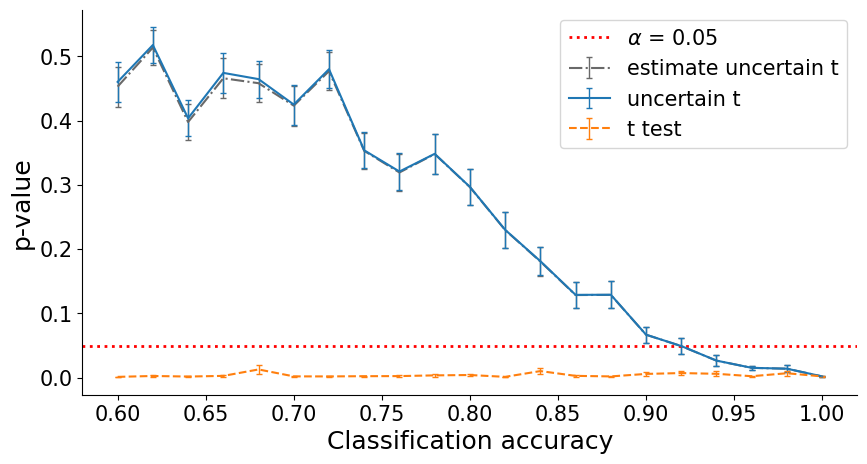

In [10]:
fig, ax=plt.subplots(figsize=(10,5))
plt.xlabel("Classification accuracy",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("p-value",fontsize=18)
plt.errorbar(prob[:,0],mean_pvalue[:,0],yerr=se_pvalue[:,0],c='dimgray',linestyle='-.',fmt='-',elinewidth=1,capsize = 2,label="estimate uncertain t")
plt.errorbar(prob[:,0],mean_pvalue[:,2],yerr=se_pvalue[:,2],elinewidth=1,capsize = 2,label="uncertain t")
plt.errorbar(prob[:,0],mean_pvalue[:,1],yerr=se_pvalue[:,1],linestyle='--',elinewidth=1,capsize = 2,label="t test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='$ \\alpha $ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(fontsize=15)

In [ ]:
# Simulation 2
# distribution of p-value under null hypothesis
np.random.seed(2022)
mu = np.repeat(np.random.random(1), repeats=2)
class_acc = np.random.uniform(0.6, 1.0, size = 2)

res_list=np.zeros(shape=(5000,3))
m=5000; n=1000
res_list=MC_comp_noisyp(m,n,mu,class_acc,sigma=0.1)

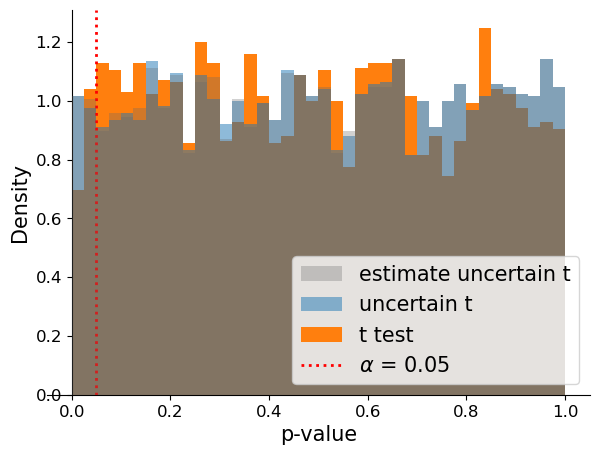

In [12]:
fig, ax=plt.subplots(figsize=(7,5))
plt.xlabel("p-value",fontsize=15)
plt.ylabel("Density",fontsize=15)
plt.hist(res_list[:,0],density=True, color='dimgray', label="estimate uncertain t", bins=40, alpha=0.3, zorder = 3)
plt.hist(res_list[:,2],density=True, label='uncertain t', bins=40, alpha=0.5, zorder = 2)
plt.hist(res_list[:,1],density=True, label="t test", bins=40, alpha=1, zorder = 1)
# plt.plot(ef,power_list[:,0],c='dimgray',linestyle='-.',label="estimate uncertain t")
# plt.plot(ef,power_list[:,2],label='uncertain t')
# plt.plot(ef,power_list[:,1],linestyle='--',label="t test")
plt.axvline(0.05,linestyle=':',c='red',linewidth=2,label='$\\alpha$ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15, loc='lower right')

In [13]:
# Simulation 3
# power
prob1=[1.0, 0.72] # accuracy
prob2=[1.0, 0.86]
prob3=[0.72, 0.72]
prob4=[0.86, 0.86]
mu=np.ones(shape=(99,2)) # mean of two group
mu[:,0]=np.arange(0.01, 1.00, 0.01)
mu[:,1]=np.arange(0.01, 1.00, 0.01)[::-1]

In [ ]:
np.random.seed(2022)
ef = np.zeros(shape=(50))
res_list=np.zeros(shape=(50,100,3))
power_list=np.zeros(shape=(50,3))
m=100;n=1000
for i in range(50):
    res_list[i]=MC_comp_noisyp(m,n,mu[i+49],prob1,sigma=0.1)
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)
    ef[i] = effect_size(mu[i+49])

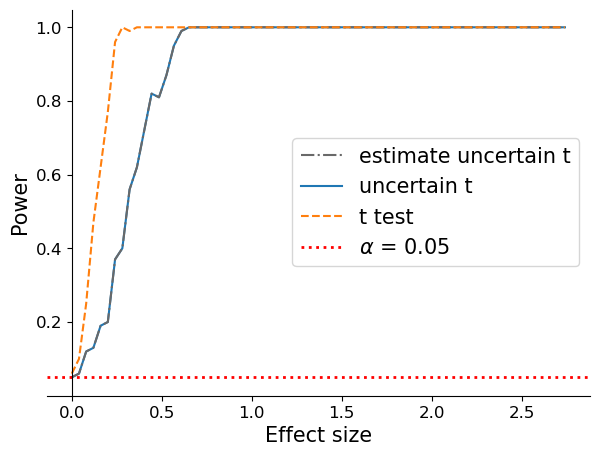

In [15]:
fig, ax=plt.subplots(figsize=(7,5))
plt.xlabel("Effect size",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.plot(ef,power_list[:,0],c='dimgray',linestyle='-.',label="estimate uncertain t")
plt.plot(ef,power_list[:,2],label='uncertain t', zorder=1)
plt.plot(ef,power_list[:,1],linestyle='--',label="t test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='$\\alpha$ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

In [ ]:
np.random.seed(2022)
ef = np.zeros(shape=(50))
res_list=np.zeros(shape=(50,100,3))
power_list=np.zeros(shape=(50,3))
m=100;n=1000
for i in range(50):
    res_list[i]=MC_comp_noisyp(m,n,mu[i+49],prob2,sigma=0.1) # different classification accuracy
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)
    ef[i] = effect_size(mu[i+49])

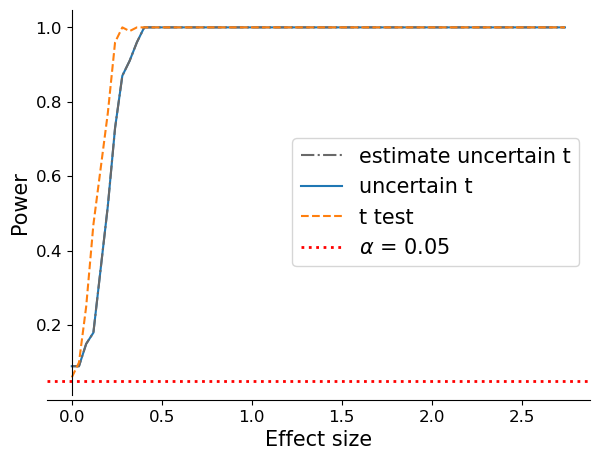

In [17]:
fig, ax=plt.subplots(figsize=(7,5))
plt.xlabel("Effect size",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.plot(ef,power_list[:,0],c='dimgray',linestyle='-.',label="estimate uncertain t")
plt.plot(ef,power_list[:,2],label='uncertain t', zorder=1)
plt.plot(ef,power_list[:,1],linestyle='--',label="t test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='$\\alpha$ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

In [ ]:
np.random.seed(2022)
ef = np.zeros(shape=(50))
res_list=np.zeros(shape=(50,100,3))
power_list=np.zeros(shape=(50,3))
m=100;n=1000
for i in range(50):
    res_list[i]=MC_comp_noisyp(m,n,mu[i+49],prob3,sigma=0.1)
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)
    ef[i] = effect_size(mu[i+49])

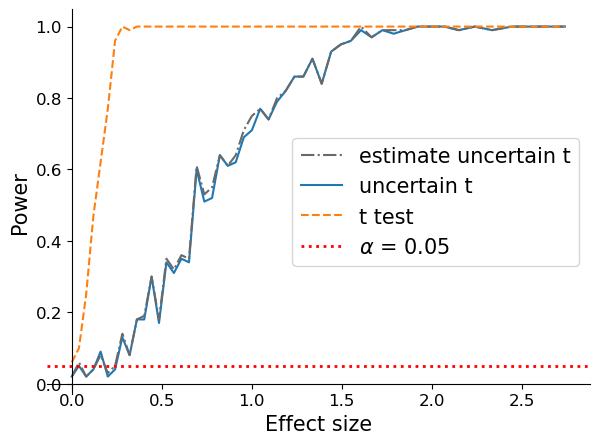

In [19]:
fig, ax=plt.subplots(figsize=(7,5))
plt.xlabel("Effect size",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.plot(ef,power_list[:,0],c='dimgray',linestyle='-.',label="estimate uncertain t")
plt.plot(ef,power_list[:,2],label='uncertain t', zorder=1)
plt.plot(ef,power_list[:,1],linestyle='--',label="t test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='$\\alpha$ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

In [ ]:
np.random.seed(2022)
ef = np.zeros(shape=(50))
res_list=np.zeros(shape=(50,100,3))
power_list=np.zeros(shape=(50,3))
m=100;n=1000
for i in range(50):
    res_list[i]=MC_comp_noisyp(m,n,mu[i+49],prob4,sigma=0.1)
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)
    ef[i] = effect_size(mu[i+49])

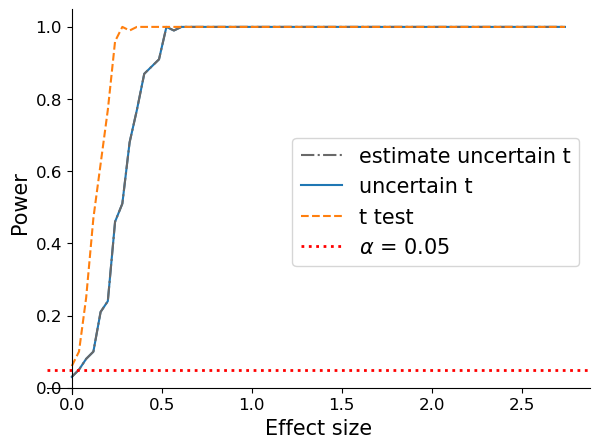

In [21]:
fig, ax=plt.subplots(figsize=(7,5))
plt.xlabel("Effect size",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.plot(ef,power_list[:,0],c='dimgray',linestyle='-.',label="estimate uncertain t")
plt.plot(ef,power_list[:,2],label='uncertain t', zorder=1)
plt.plot(ef,power_list[:,1],linestyle='--',label="t test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='$\\alpha$ = 0.05')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)